# Lab 5

This lab extends binary logistic regression to [multi-class logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression), which goes by a variety of names, including *softmax regression*, due to the use of the softmax function, which generalizes the logistic function.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

We again load the Fashion MNIST dataset, though this time around, we'll use all 10 output classes.

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

4422102/4422102 [==============================] - 0s 0us/step


### Cross-Entropy Loss

Recall the log loss function (also called binary cross-entropy):

\begin{equation}
-y log(\hat{y}) + (1−y)log(1−\hat{y})
\end{equation}

In the above formulation, it is assumed that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

## Build a model

Let's construct a model much like we did in the binary classification case, but now with a multi-class output.

---
### Exercise 1 (8 points)

Fill in the NotImplemented parts of the build_model function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output will include 10 probabilities instead of 1.
* Use a softmax function instead of a sigmoid.
* Use a [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of binary_crossentropy. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

In [3]:
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      # Need output of 10 probabilities and to use softmax
      units= 10, #output probabilities 
      activation='softmax' #Using softmax function instead of sigmoid
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
  # using the sparse categorical crossentropy
  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

---

Make sure your model trains. If you configured it properly, the training loss should get to ~0.55 after 5 epochs.

In [4]:
model = build_model(len(label_names), 0.01)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
844/844 [==============================] - 12s 10ms/step - loss: 1.0042 - accuracy: 0.6881 - val_loss: 0.7645 - val_accuracy: 0.7467
Epoch 2/5
844/844 [==============================] - 2s 3ms/step - loss: 0.6844 - accuracy: 0.7815 - val_loss: 0.6665 - val_accuracy: 0.7763
Epoch 3/5
844/844 [==============================] - 2s 3ms/step - loss: 0.6155 - accuracy: 0.8031 - val_loss: 0.6216 - val_accuracy: 0.7915
Epoch 4/5
844/844 [==============================] - 2s 3ms/step - loss: 0.5781 - accuracy: 0.8134 - val_loss: 0.5972 - val_accuracy: 0.7983
Epoch 5/5
844/844 [==============================] - 2s 3ms/step - loss: 0.5539 - accuracy: 0.8200 - val_loss: 0.5751 - val_accuracy: 0.8060


,loss,accuracy,val_loss,val_accuracy
0,1.004237,0.688056,0.764544,0.746667
1,0.684417,0.781500,0.666501,0.776333
2,0.615518,0.803148,0.621554,0.791500
3,0.578128,0.813352,0.597186,0.798333
4,0.553908,0.819981,0.575056,0.806000


### Evaluation Metrics

Classification metrics like accuracy, precision, and recall can all be derived from a confusion matrix which displays the counts for all pairs of true label and predicted label. Correct predictions are on the diagonal and incorrect predictions (confusions) are off the diagonal.

First, we need the predicted labels from the model.

In [5]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 1s 2ms/step
[9 2 1 ... 8 1 5]


Next, we create a confusion matrix and produce an easy-to-read visualization.

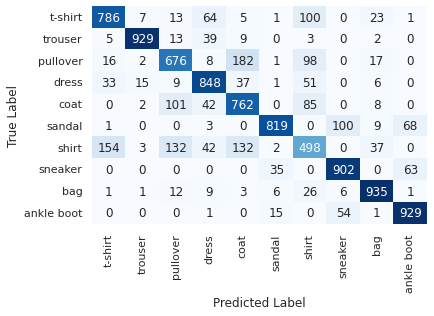

In [6]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

---
### Exercise 2 (8 points)

Answer the following questions by studying the confusion matrix (above).

1. Which class has the lowest precision? What is that precision? Which class has the highest precision? What is that precision?

2. For the class 'sneaker', what class is the largest source of false negatives? What about the largest source of false positives?

In [7]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, test_predictions, target_names=label_names))

              precision    recall  f1-score   support

     t-shirt       0.79      0.79      0.79      1000
     trouser       0.97      0.93      0.95      1000
    pullover       0.71      0.68      0.69      1000
       dress       0.80      0.85      0.82      1000
        coat       0.67      0.76      0.72      1000
      sandal       0.93      0.82      0.87      1000
       shirt       0.58      0.50      0.54      1000
     sneaker       0.85      0.90      0.87      1000
         bag       0.90      0.94      0.92      1000
  ankle boot       0.87      0.93      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



*Written answer:*


1. The shirt class has the lowest percision at 0.58; the trouser class has the highest percision at 0.97 

2. Largest sourse of false negatives for sneaker (true label) are the class ankle boot (predicted label); the largest source of false positivies for sneaker (predicted label) are the class sandal (true label).  

---

## Analyze Errors

A crucial part of the development cycle in Machine Learning is analyzing errors to help understand the shortcomings of the model. While typically we'd want to use the development data for this purpose to preserve the purity of the test set, we'll just use our test split for simplicity.

Since the "shirt" class seems to be the source for a lot of errors, let's look at some of the confusions.

---
### Exercise 3 (8 points)

1. Display 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).
2. Display 5 images with predicted label "shirt", but true label "coat" (false positives for the "shirt" class).

Sanity check to make sure it matches findings from above:
False Positives: 85
False Negatives: 132

False Negatives: True Label = Shirt


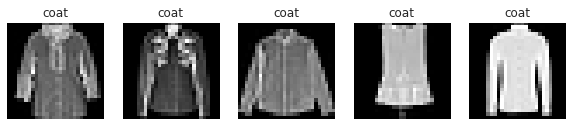


False Positives: True Label = Coat


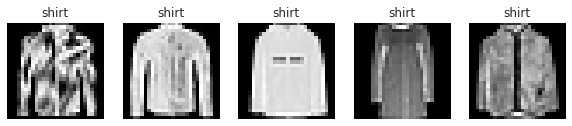

In [8]:
#Use inerselectid to find the values between two intersecting arrays
  #false_positives = np.intersect1d(np.where(Y_test == label_names.index('coat')), np.where(test_predictions == label_names.index('shirt')))
  #false_negatives = np.intersect1d(np.where(Y_test == label_names.index('shirt')), np.where(test_predictions == label_names.index('coat')))


#A simplified option where [0] is indicies of Predicted label = "shirt" & True label = "coat"
false_positives = np.where((Y_test == 4) & (test_predictions == 6))[0]

#False negatives: True label = "shirt" & predicted label = "coat"
false_negatives = np.where((Y_test == 6) & (test_predictions == 4))[0]

print('Sanity check to make sure it matches findings from above:')
print('False Positives:', len(false_positives))
print('False Negatives:', len(false_negatives))


#Plots for False Negatives where the true label "shirt", 
#but predicted label "coat"
print('\nFalse Negatives: True Label = Shirt')
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_test[false_negatives[i]]
  axs[i].imshow(image, cmap='gray')
  axs[i].set_title('coat')
  axs[i].axis('off')
plt.show()

#Plots for False Positives where the predicted label "shirt", 
#but true label "coat"
print('\nFalse Positives: True Label = Coat')
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10,5))
for i in range(5):
  image = X_test[false_positives[i]]
  axs[i].imshow(image, cmap='gray')
  axs[i].set_title('shirt')
  axs[i].axis('off')
plt.show()

---

## Visualize Parameters
Finally, here's some code that helps visualize the learned parameters for each class.

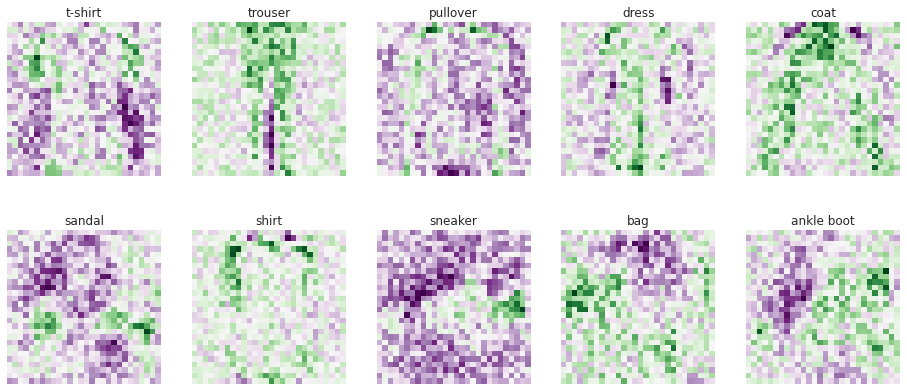

In [9]:
weights, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(2, 5, figsize=(16,7))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(weights[:,i].reshape(28,28), cmap='PRGn')
  ax.axis('off')
  ax.set_title(label_names[i])
plt.show()